In [1]:
import json
import time

import numpy as np
import seaborn as sn

from classify import classify_subcategory

np.random.seed(0)

questions = open('tossups.json').readlines() + open('bonuses.json').readlines()
np.random.shuffle(questions)
questions = questions[:int(0.2*len(questions))]
print('Number of questions in test set:', len(questions))

with open('subcategories.txt') as f:
    SUBCATEGORIES = [line.strip() for line in f.readlines()]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Number of questions in test set: 55289


In [2]:
EPSILON = 0.01

print('=====Begin Testing=====')
time_now = time.perf_counter()

counter = 0
correct = 0
confusion_matrix = [[0 for _ in range(len(SUBCATEGORIES))] for _ in range(len(SUBCATEGORIES))]

for line in questions:
    data = json.loads(line)

    if 'subcategory' not in data:
        continue

    subcategory = data['subcategory']

    if subcategory not in SUBCATEGORIES:
        continue

    counter += 1

    if data['type'] == 'tossup':
        prediction = classify_subcategory(data['question'] + ' ' + data['answer'], EPSILON)

    if data['type'] == 'bonus' and 'parts' in data and len(data['parts']) == 3:
        prediction = classify_subcategory(data['leadin'] + ' ' + ' '.join(data['parts']) + ' ' + ' '.join(data['answers']), EPSILON)

    subcategory_index = SUBCATEGORIES.index(subcategory)
    prediction_index = SUBCATEGORIES.index(prediction)

    confusion_matrix[subcategory_index][prediction_index] += 1

    if subcategory == prediction:
        correct += 1

    if counter % 10000 == 0:
        print(f'{correct}/{counter}')

print('=====End Testing=====')
print(f'Accuracy: {100 * correct / counter}% ({correct}/{counter})')
print(f'Time: {time.perf_counter() - time_now} seconds')

=====Begin Testing=====
8514/10000
17080/20000
25665/30000
34178/40000
42693/50000
=====End Testing=====
Accuracy: 85.35446205170976% (46053/53955)
Time: 19.45173375 seconds


In [3]:
for i, subcat in enumerate(SUBCATEGORIES):
    accuracy = 0.0 if sum(confusion_matrix[i]) == 0 else confusion_matrix[i][i] / sum(confusion_matrix[i])
    accuracy = round(100 * accuracy, 2)
    print(f'{subcat + ":":21} {str(confusion_matrix[i][i]) + "/" + str(sum(confusion_matrix[i])):10} ({accuracy}%)')

American Literature:  2973/3643  (81.61%)
British Literature:   2574/2919  (88.18%)
European Literature:  2065/2343  (88.13%)
World Literature:     1538/1797  (85.59%)
American History:     3063/3646  (84.01%)
Ancient History:      678/812    (83.5%)
European History:     3400/4161  (81.71%)
World History:        2634/3300  (79.82%)
Biology:              2603/2855  (91.17%)
Chemistry:            2125/2421  (87.77%)
Physics:              2613/2924  (89.36%)
Other Science:        2382/2761  (86.27%)
Visual Fine Arts:     2843/3243  (87.67%)
Auditory Fine Arts:   2621/3050  (85.93%)
Other Fine Arts:      1149/1606  (71.54%)
Religion:             1859/2105  (88.31%)
Mythology:            2267/2543  (89.15%)
Philosophy:           2033/2239  (90.8%)
Social Science:       1750/2013  (86.93%)
Current Events:       435/626    (69.49%)
Geography:            1393/1670  (83.41%)
Trash:                1055/1278  (82.55%)


In [4]:
print('Confusion Matrix:')
for subcat, row in zip(SUBCATEGORIES, confusion_matrix):
    print(f'{subcat:20}', row)

Confusion Matrix:
American Literature  [2973, 123, 124, 127, 26, 5, 13, 6, 3, 1, 5, 5, 9, 6, 43, 12, 12, 21, 18, 3, 4, 104]
British Literature   [106, 2574, 62, 53, 11, 4, 15, 3, 1, 0, 1, 4, 4, 3, 13, 7, 19, 10, 5, 1, 3, 20]
European Literature  [44, 78, 2065, 44, 3, 4, 15, 2, 0, 2, 2, 2, 4, 3, 10, 5, 22, 13, 6, 0, 7, 12]
World Literature     [69, 55, 57, 1538, 2, 2, 4, 2, 3, 2, 3, 1, 3, 3, 7, 4, 18, 8, 7, 3, 1, 5]
American History     [33, 11, 4, 5, 3063, 15, 63, 78, 0, 4, 5, 5, 13, 1, 16, 20, 2, 11, 40, 143, 63, 51]
Ancient History      [1, 2, 2, 1, 6, 678, 39, 47, 2, 1, 1, 0, 5, 1, 1, 8, 6, 4, 0, 3, 4, 0]
European History     [15, 16, 18, 8, 87, 168, 3400, 146, 6, 4, 5, 6, 12, 7, 25, 31, 9, 31, 16, 64, 66, 21]
World History        [8, 10, 2, 16, 70, 101, 143, 2634, 2, 3, 1, 6, 14, 2, 8, 33, 10, 6, 9, 95, 109, 18]
Biology              [12, 3, 3, 4, 17, 3, 5, 5, 2603, 45, 12, 31, 3, 2, 7, 2, 5, 6, 44, 4, 27, 12]
Chemistry            [5, 6, 3, 0, 7, 1, 5, 4, 51, 2125, 165, 26, 2, 1, 3,

<Axes: >

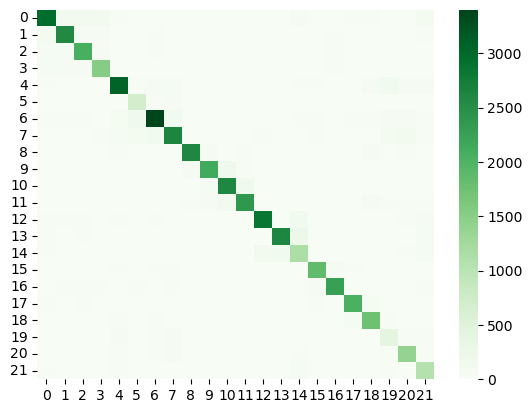

In [5]:
sn.heatmap(confusion_matrix, cmap='Greens', annot=False)

<Axes: >

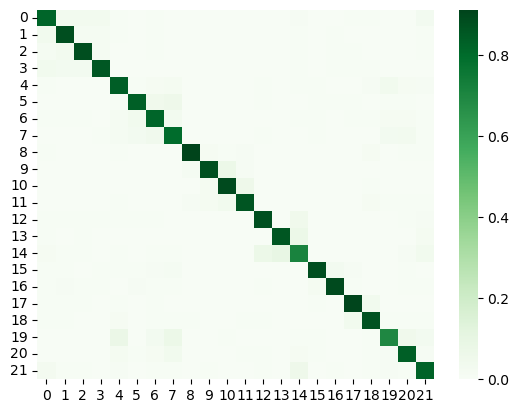

In [6]:
# use relative proportions instead of absolute values
sn.heatmap([[confusion_matrix[i][j] / sum(confusion_matrix[i]) for j in range(len(confusion_matrix[i]))] for i in range(len(confusion_matrix))], cmap='Greens', annot=False)